# Historical Variance

Let's see how we'd be calculating a covariance matrix of assets without the help of a factor model

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/68/1e/116ad560de97694e2d0c1843a7a0075cc9f49e922454d32f49a80eb6f1f2/numpy-1.14.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/11/09/e66eb844daba8680ddff26335d5b4fead77f60f957678243549a8dd4830d/pandas-0.18.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/99/a6/8214b6564bf4ace9bec8a26e7f89832792be582c042c47c912d3201328a0/plotly-2.2.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/15/d3/689f2a940478b82ac57c751a40460598221fd82b0449a7a8f7eef47a3bcc/zipline-1.2.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/2f/d9/16ac346f7c0102835814cc9e5b684aaadea101560bb932a2403bd26b2320/Logbook-1.5.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/77/86/cdb5e8eaed90796aa83a6d9f75cfbd37af553c47a291cd47bc410ef9bdb2/requests_file-1.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/40/c5/cc720f531bbde0efeab940de400d0fcc95e87

In [6]:
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [8]:
import os
import quiz_helper
from zipline.data import bundles

In [9]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Overwriting bundle with name 'm4-quiz-eod-quotemedia'
  This is separate from the ipykernel package so we can avoid doing imports until


### Build pipeline engine

In [10]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [11]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

In [12]:
len(universe_tickers)

490

In [13]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [14]:
from quiz_helper import get_pricing

## get pricing data into a dataframe

In [15]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

Equity(0 [A])  Equity(1 [AAL])  Equity(2 [AAP])  \
2011-01-07 00:00:00+00:00       0.008437         0.014230         0.026702   
2011-01-10 00:00:00+00:00      -0.004174         0.006195         0.007435   
2011-01-11 00:00:00+00:00      -0.001886        -0.043644        -0.005927   
2011-01-12 00:00:00+00:00       0.017254        -0.008237         0.013387   
2011-01-13 00:00:00+00:00      -0.004559         0.000955         0.003031   
2011-01-14 00:00:00+00:00       0.003439        -0.009156         0.003022   
2011-01-18 00:00:00+00:00       0.034254        -0.062085        -0.004286   
2011-01-19 00:00:00+00:00      -0.010224        -0.008929         0.008754   
2011-01-20 00:00:00+00:00      -0.008496         0.021953        -0.004732   
2011-01-21 00:00:00+00:00       0.007873        -0.041038         0.005544   
2011-01-24 00:00:00+00:00       0.014646         0.027473        -0.001106   
2011-01-25 00:00:00+00:00      -0.006736         0.002982         0.009146   
2011-01-26 00:00:00+00:00      -0.030736         0.066133         0.003593   
2011-01-27 00:00:00+00:00       0.007721         0.023178        -0.001553   
2011-01-28 00:00:00+00:00      -0.018846        -0.080553        -0.000936   
2011-01-31 00:00:00+00:00       0.003608        -0.023615        -0.002351   
2011-02-01 00:00:00+00:00       0.011654        -0.001047        -0.009218   
2011-02-02 00:00:00+00:00       0.010112        -0.039304        -0.027477   
2011-02-03 00:00:00+00:00      -0.000289         0.007310         0.014126   
2011-02-04 00:00:00+00:00       0.005627        -0.036500         0.024014   
2011-02-07 00:00:00+00:00       0.007709         0.052046         0.008114   
2011-02-08 00:00:00+00:00       0.010854         0.016455         0.006202   
2011-02-09 00:00:00+00:00       0.004664         0.000000         0.016955   
2011-02-10 00:00:00+00:00       0.000413        -0.003048        -0.011367   
2011-02-11 00:00:00+00:00      -0.007150         0.028364         0.000764   
2011-02-14 00:00:00+00:00       0.001663        -0.015790        -0.023274   
2011-02-15 00:00:00+00:00      -0.011905         0.011043        -0.003926   
2011-02-16 00:00:00+00:00       0.015123         0.001958         0.013860   
2011-02-17 00:00:00+00:00      -0.003311        -0.017791        -0.024844   
2011-02-18 00:00:00+00:00       0.011078        -0.020103        -0.006693   
...                                  ...              ...              ...   
2015-11-20 00:00:00+00:00       0.001072        -0.002373         0.002767   
2015-11-23 00:00:00+00:00      -0.007094         0.002379        -0.001228   
2015-11-24 00:00:00+00:00       0.002085        -0.025309         0.003504   
2015-11-25 00:00:00+00:00      -0.008206         0.001938         0.006805   
2015-11-27 00:00:00+00:00      -0.003256         0.009201         0.003285   
2015-11-30 00:00:00+00:00      -0.010209        -0.010321        -0.012798   
2015-12-01 00:00:00+00:00       0.015748         0.048493        -0.002396   
2015-12-02 00:00:00+00:00      -0.005284         0.012930        -0.027166   
2015-12-03 00:00:00+00:00      -0.009521        -0.012555        -0.019944   
2015-12-04 00:00:00+00:00       0.020199         0.039303         0.006779   
2015-12-07 00:00:00+00:00      -0.000340         0.018020        -0.029578   
2015-12-08 00:00:00+00:00      -0.023307        -0.026876        -0.008866   
2015-12-09 00:00:00+00:00      -0.005170        -0.020213         0.022223   
2015-12-10 00:00:00+00:00       0.015039         0.010092        -0.009466   
2015-12-11 00:00:00+00:00      -0.012227        -0.045356        -0.019179   
2015-12-14 00:00:00+00:00      -0.011197        -0.007618        -0.008325   
2015-12-15 00:00:00+00:00       0.024683         0.019768         0.057990   
2015-12-16 00:00:00+00:00       0.010780         0.014190         0.029771   
2015-12-17 00:00:00+00:00      -0.017212        -0.017122        -0.048190   
2015-12-18 00:00:00+00:00      -0.041084        -

## Quiz 1

Check out the [numpy.cov documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.cov.html).  Then think about what's wrong with the following use of numpy.cov

In [16]:
# What's wrong with this?
annualization_factor = 252
covariance_assets_not_correct = annualization_factor*np.cov(returns_df)

In [17]:
## TODO: Check the shape of the covariance matrix
covariance_assets_not_correct.shape

(1256, 1256)

## Answer 1 here:

The dataframe `returns_df` needs to be transposed because the observations need to be on the columns

## Quiz 2
How can you adjust the input so that we get the desired covariance matrix of assets?

In [39]:
# TODO: calculate the covariance matrix of assets
annualization_factor = 252
covariance_assets = annualization_factor * np.cov(returns_df.T)

In [40]:
covariance_assets.shape

(490, 490)

## Answer 2:

Transposing `returns_df`

## Visualize the covariance matrix

In [20]:
import seaborn as sns

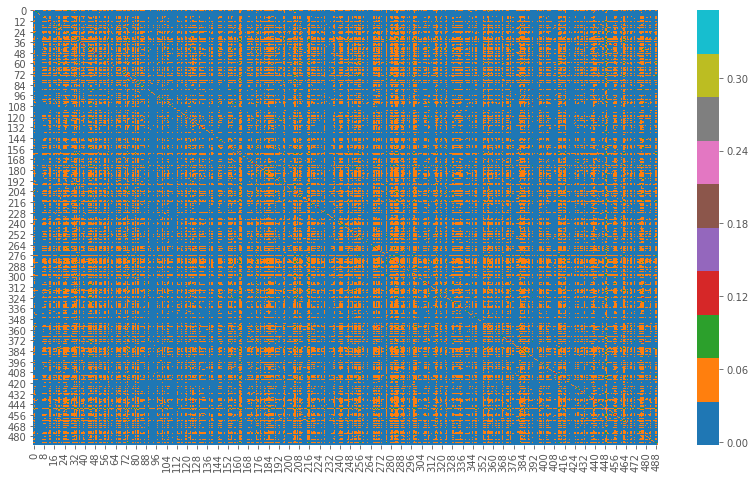

In [41]:
# view a heatmap of the covariance matrix
sns.heatmap(covariance_assets,cmap='tab10');
## If the colors aren't distinctive, please try a couple of these color schemes:
## cmap = 'tab10'
# cmap = 'Accent'

In [42]:
m = covariance_assets.shape[0]
c1 = covariance_assets[0:m, 1]
np.median(c1)

# list containing median covariance for all 490 assets
# it is the median of the first half of the matrix
median_cov = []
max_cov = []

for i in range(m):
    c_i = covariance_assets[i:m, i]
    median_cov.append(np.median(c_i))
    max_cov.append(np.max(c_i))

print(f"The median of all covar is {np.median(median_cov)} - while the median of the maximum is {np.median(max_cov)}")

The median of all covar is 0.026117319400875534 - while the median of the maximum is 0.06446316385982571


## Quiz 3
Looking at the colormap are covariances more likely to be positive or negative?  Are covariances likely to be above 0.10 or below 0.10?

## Answer 3 here:
The covariances are all POSITIVE and they are all much smaller than 0.10 (they are around 0.001).

## Fun Quiz!
Do you know what the [seaborn visualization package](https://seaborn.pydata.org/index.html) was named after?

## Fun Answer! here 
As an anecdote, it might be interesting for you to know that the import convention sns comes from the fictional character Samuel Norman “Sam” Seaborn on the television serial drama The West Wing. It’s an inside joke by the core developer of Seaborn, namely, Michael Waskom.

## Solutions
The [solution notebook is here](historical_variance_solution.ipynb)